In [ ]:
import google.generativeai as genai
import base64, json, datetime
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR   = "/content/drive/MyDrive/maddata-hackathon-2026/datasets/dataset"

In [ ]:
GEMINI_API_KEY = "<API KEY HERE>"

In [ ]:
# Configure — free API key from aistudio.google.com
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel("gemini-2.5-flash-lite")  # most generous free tier

In [ ]:
def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

In [ ]:
def scan_road_image(image_path, gps_lat=None, gps_lng=None):

    image_data = encode_image(image_path)

    prompt = """
    You are a road damage detection system. Analyze this road image and detect any of the following issues:
    - Potholes
    - Cracks or damaged road surface
    - Broken or missing road signs
    - Litter or debris on road
    - Illegal parking
    - Faded road markings

    Respond ONLY in this exact JSON format:
    {
      "issues_detected": true/false,
      "issues": [
        {
          "type": "issue name",
          "severity": "LOW/MEDIUM/HIGH",
          "description": "brief description",
          "location_in_image": "left/center/right/full"
        }
      ],
      "overall_road_condition": "GOOD/FAIR/POOR/CRITICAL",
      "recommended_action": "brief action text"
    }
    """

    response = model.generate_content([
        {"mime_type": "image/jpeg", "data": image_data},
        prompt
    ])

    # Parse response
    raw = response.text.strip().replace("```json", "").replace("```", "")
    detection = json.loads(raw)

    # Auto-generate maintenance ticket
    ticket = {
        "ticket_id": f"RS-{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}",
        "timestamp": str(datetime.datetime.now()),
        "image": image_path,
        "gps": {"lat": gps_lat, "lng": gps_lng},
        "road_condition": detection["overall_road_condition"],
        "issues": detection["issues"],
        "total_issues": len(detection["issues"]),
        "recommended_action": detection["recommended_action"],
        "status": "OPEN"
    }

    return ticket

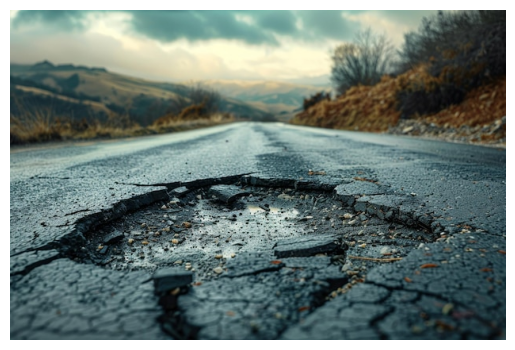

{
  "ticket_id": "RS-20260222020226",
  "timestamp": "2026-02-22 02:02:26.660067",
  "image": "/content/drive/MyDrive/maddata-hackathon-2026/datasets/dataset/train/potholes/synthetic/potholes_synthetic_000067.jpg",
  "gps": {
    "lat": 37.7749,
    "lng": -122.4194
  },
  "road_condition": "CRITICAL",
  "issues": [
    {
      "type": "Potholes",
      "severity": "HIGH",
      "description": "A large pothole is present in the center of the road, with broken asphalt surrounding it.",
      "location_in_image": "center"
    },
    {
      "type": "Cracks or damaged road surface",
      "severity": "MEDIUM",
      "description": "The road surface is heavily cracked, especially around the pothole, indicating significant wear and tear.",
      "location_in_image": "full"
    }
  ],
  "total_issues": 2,
  "recommended_action": "Immediate repair of the pothole and resurfacing of the damaged road section is required to ensure road safety.",
  "status": "OPEN"
}


In [ ]:
# --- USAGE ---
IMAGE_PATH = f"{DATA_DIR}/train/potholes/synthetic/potholes_synthetic_000067.jpg"

img = Image.open(IMAGE_PATH)
plt.imshow(img)
plt.axis("off")
plt.show()
ticket = scan_road_image(
    image_path=IMAGE_PATH,
    gps_lat=37.7749, # dummy
    gps_lng=-122.4194, # dummy
)

print(json.dumps(ticket, indent=2))